In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from scipy.stats import norm
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split

2023-12-07 13:06:29.459455: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading the data

In [2]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

## Step 0: Analyzing the data

A good first step is to analyze the data before training. Are there any missing values? Are there any clear outliers? For boston housing, the 9th covariate is categorical. We could one-hot encode this during the preprocessing.

In [3]:
data[0:5]

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, 0.0000e+00, 5.3800e-01,
        6.5750e+00, 6.5200e+01, 4.0900e+00, 1.0000e+00, 2.9600e+02,
        1.5300e+01, 3.9690e+02, 4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, 0.0000e+00, 4.6900e-01,
        6.4210e+00, 7.8900e+01, 4.9671e+00, 2.0000e+00, 2.4200e+02,
        1.7800e+01, 3.9690e+02, 9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, 0.0000e+00, 4.6900e-01,
        7.1850e+00, 6.1100e+01, 4.9671e+00, 2.0000e+00, 2.4200e+02,
        1.7800e+01, 3.9283e+02, 4.0300e+00],
       [3.2370e-02, 0.0000e+00, 2.1800e+00, 0.0000e+00, 4.5800e-01,
        6.9980e+00, 4.5800e+01, 6.0622e+00, 3.0000e+00, 2.2200e+02,
        1.8700e+01, 3.9463e+02, 2.9400e+00],
       [6.9050e-02, 0.0000e+00, 2.1800e+00, 0.0000e+00, 4.5800e-01,
        7.1470e+00, 5.4200e+01, 6.0622e+00, 3.0000e+00, 2.2200e+02,
        1.8700e+01, 3.9690e+02, 5.3300e+00]])

You can finish the analyzing step yourself, for instance by adding some pairwise plots.

## Step 1: Preprocessing

It is rare that data does not need some form of preprocessing before training a model. At the very least, we want to standardize the data and split it in a training set, test set, and validation set. Note that for smaller sets, cross-validation is a good alternative. The idea of this split is that we use the training set to train, the validation set to find the optimal hyperparameters, and then the test set to get an estimate of the performance of the model.

In [4]:
X_train, X_rest, Y_train, Y_rest = train_test_split(data, target, test_size=0.3) # Set aside 30% of the data set
X_test, X_val, Y_test, Y_val = train_test_split(X_rest, Y_rest, test_size=0.5) # Split this 30% in half

We standardize the covariates and targets (why?). Make sure to only use information from the training set!

In [5]:
X_mean = np.mean(X_train, axis=0)
X_std = np.std(X_train, axis=0)
Y_mean = np.mean(Y_train)
Y_std = np.mean(Y_train)

X_train_n = (X_train - X_mean) / X_std
X_test_n = (X_test - X_mean) / X_std
X_val_n = (X_val - X_mean) / X_std

Y_train_n = (Y_train - Y_mean) / Y_std
Y_test_n = (Y_test - Y_mean) / Y_std
Y_val_n = (Y_val - Y_mean) / Y_std


More can be done in this step, for instance one-hot encoding the categorical variable.

## Step 2: Creating a model

In this notebook, we make a simple neural network using keras and tensorflow. Note that pytorch also has an excellent framework to do this. We will use the functional approach instead of the sequential approach. The difference is explained very well online.

In [6]:
n_dim = len(X_train[0])

inputs = Input(shape=(n_dim,))
x = Dense(30, activation='relu')(inputs)  # Look up what the function is of 'relu'
x = Dense(30, activation='relu')(x)
x = Dense(30, activation='relu')(x)
outputs = Dense(1)(x)

# Create the actual model
model = Model(inputs=inputs, outputs=outputs)

# Compile
model.compile(optimizer='adam', loss='mse')  # Use 'categorical_crossentropy' for classification

# Get a summary of the model, check if everything is as intended
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense (Dense)               (None, 30)                420       
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dense_2 (Dense)             (None, 30)                930       
                                                                 
 dense_3 (Dense)             (None, 1)                 31        
                                                                 
Total params: 2311 (9.03 KB)
Trainable params: 2311 (9.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
model.fit(X_train_n, Y_train_n, epochs=500, batch_size=50, verbose=0)

Note that the performance of the model on the training set is much better than on the test set. This overfitting is very common for neural networks and special steps need to be taken to prevent this. Common approaches are to training for shorter, use restore the weights to the epoch with the lowest test-loss, adding l2-regularization, adding dropout. All these techniques are explained perfectly online.

In [8]:
print(model.evaluate(X_train_n, Y_train_n))
print(model.evaluate(X_test_n, Y_test_n))

12/12 [==============================] - 0s 2ms/step - loss: 0.0013
0.0013357722200453281
3/3 [==============================] - 0s 4ms/step - loss: 0.0229
0.022936388850212097


We will now train a second, smaller, network, that estimates the error of the first network

In [11]:
train_Z = (Y_train_n - model.predict(X_train_n)[:, 0])**2

12/12 [==============================] - 0s 2ms/step


In [12]:
inputs = Input(shape=(n_dim,))
x = Dense(20, activation='relu')(inputs)  # Look up what the function is of 'relu'
x = Dense(20, activation='relu')(x)
outputs = Dense(1, activation='softplus')(x)  # We use a softplus activation to enforce positivity

# Create the actual model
model_var = Model(inputs=inputs, outputs=outputs)

# Compile the model
model_var.compile(optimizer='adam', loss='mse')

# Fit the model
model_var.fit(X_train_n, train_Z, epochs = 300, batch_size = 50, verbose = 0)

In [13]:
print(model_var.predict(X_test_n)[0:10])

3/3 [==============================] - 0s 3ms/step
[[0.00335569]
 [0.00737388]
 [0.00037336]
 [0.00045097]
 [0.00139479]
 [0.00045667]
 [0.00402264]
 [0.00216159]
 [0.00069413]
 [0.00239409]]


## Step 3: Optimizing the hyperparameters (not implemented)

This step is generally the most work. We have until now chosen many hyperparameters such as total training time, batch-size, choice of activation, choice of optimizer, and network architecture. All of these choices have an effect on the model performance and your first guess is rarely the best one. We must use the validation and test set the find the best model and to evaluate its performance. There are nice custom made tools for this, many of which can be found in the sklearn library.

## Additional model validation

3/3 [==============================] - 0s 8ms/step


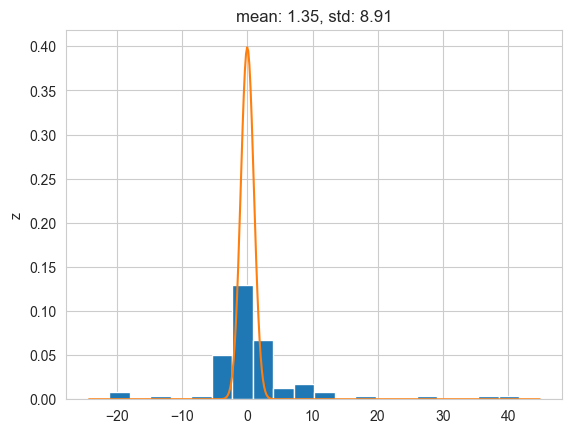

In [16]:
z_scores = (Y_test_n - model.predict(X_test_n)[:, 0]) / np.sqrt(model_var.predict(X_test_n)[:, 0])
plt.hist(z_scores, density=True, bins=20)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 400)
p = norm.pdf(x, 0, 1)
plt.plot(x, p)
plt.ylabel('z')
plt.title(f'mean: {np.round(np.mean(z_scores),2)}, std: {np.round(np.std(z_scores),2)}')
plt.show()

Conclusion: we are underestimating the variance. This is likely caused by overfitting, highlighting the importance of a good hyperparameter search

Can we get a rough idea of how important each covariate is? We take the average input and see what the effect is of adding 0.1 to each of the covariates.

In [21]:
original_predictions = model.predict(X_test_n, verbose=0)
importance = np.zeros(n_dim)
for i in range(n_dim):
  test_data_imp = X_test_n
  test_data_imp[:, i] = X_test_n[:,i]+0.1
  predictions_imp = model.predict(test_data_imp, verbose=0)
  importance[i]=10*np.mean(np.abs(predictions_imp - original_predictions))

In [22]:
importance

array([0.14183368, 0.20716552, 0.1661144 , 0.19338911, 0.19079398,
       0.22750515, 0.18929927, 0.23143604, 0.27530065, 0.32240868,
       0.34379695, 0.37838869, 0.4471752 ])

We repeat this idea, but instead of only adding 0.1, we take each covariate through the entire range of values in the test set. This gives a visual intuition on how each covariate influences the model predictions.

In [23]:
m_test_data = np.mean(X_test_n, axis=0)

M=20
test_values = np.zeros((n_dim, M))
m_pred = np.zeros((n_dim, M))
for index in range(n_dim):
  test_x = np.linspace(min(X_test_n[:,index]),max(X_test_n[:,index]), M)
  test_values[index] = test_x
  for i in range(M):
    x_perturbed = m_test_data
    x_perturbed[index] = test_x[i]
    m_pred[index, i]= model.predict(np.array([x_perturbed]), verbose=0)

/var/folders/gs/qmtxgkvd04l0qd255jxrzrz00000gn/T/ipykernel_63143/1854474064.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m_pred[index, i]= model.predict(np.array([x_perturbed]), verbose=0)


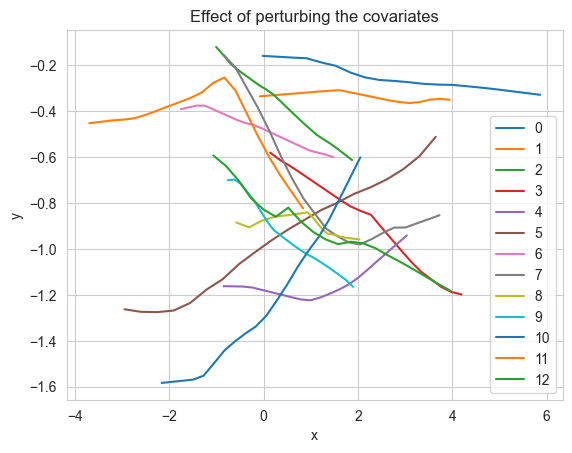

In [24]:
for index in range(n_dim):
  plt.plot(test_values[index], m_pred[index], label=index)
plt.legend()
plt.title('Effect of perturbing the covariates')
plt.ylabel('y')
plt.xlabel('x')
plt.show()